In [140]:
# You may want to install "gprof2dot"
import io
from collections import Counter

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
from rcviz import callgraph, viz
from save_csv import results_to_csv

import pydot

In [146]:
eps = 1e-5  # a small number
np.random.seed(69420)

class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, m=0):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.m = m

    @staticmethod
    def information_gain(X, y, thresh):
        lsplit = y[X < thresh]
        rsplit = y[X >= thresh]
        
        ans = DecisionTree.gini_impurity(X,y,thresh) - (len(lsplit)*DecisionTree.gini_impurity(X,lsplit,thresh) + len(rsplit)*DecisionTree.gini_impurity(X,rsplit,thresh))/len(y)
        return ans

    @staticmethod
    def gini_impurity(X, y, thresh):
        if len(y) == 0:
            return 0
        
        n_yes = 0
        n_no = 0
        for pred in y:
            if pred == 0:
                n_no += 1
            else:
                n_yes += 1
        p_yes = n_yes/len(y)
        p_no = n_no/len(y)
        
        return p_yes*(1-p_yes) + p_no*(1-p_no)

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0 and 0 <= self.m and self.m <= len(X[0]):
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            if self.m == 0:
                feature_idxs = np.arange(X.shape[1])
            else:
                feature_idxs = np.random.choice(np.arange(X.shape[1]), size=m, replace=False)
                feature_idxs.sort()
                
            X_f = X[:, feature_idxs]
                
            thresh = np.array([
                    np.linspace(np.min(X_f[:, i]) + eps, np.max(X_f[:, i]) - eps, num=10)
                    for i in range(X_f.shape[1])
            ])
                
            for i in range(X_f.shape[1]):
                gains.append([self.information_gain(X_f[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat


class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=3, params=None, n=200, feature_labels=None, sample_n=0, m=0):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.max_depth = max_depth
        self.sample_n = sample_n
        self.decision_trees = [
            DecisionTree(max_depth=self.max_depth, feature_labels=feature_labels, m=m)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        votes = []
        for i in range(len(self.decision_trees)):
            if self.sample_n == 0:
                rand_idxs = np.random.randint(len(X), size=len(X))
            else:
                rand_idxs = np.random.randint(len(X), size=self.sample_n)
            self.decision_trees[i] = self.decision_trees[i].fit(X[rand_idxs, :], y[rand_idxs])
    
        return self

    def predict(self, X):
        votes = []
        for i in range(len(self.decision_trees)):
            votes.append(self.decision_trees[i].predict(X))
            
        return stats.mode(votes).mode[0]


class RandomForest(BaggedTrees):
    def __init__(self, max_depth=3, params=None, n=200, m=1, feature_labels=None, sample_n=0):
        if params is None:
            params = {}
        BaggedTrees.__init__(self, max_depth=max_depth, params=params, feature_labels=feature_labels, n=n, sample_n=sample_n)
        self.m = m


class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO implement function
        return self

    def predict(self, X):
        # TODO implement function
        pass


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)

In [147]:
if __name__ == "__main__":
    dataset = "titanic"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "titanic":
        # Load titanic data
        path_train = 'data/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = 'data/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0]
        y = np.array(y[labeled_idx], dtype=np.int)
        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, 1:]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'data/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features:", features)
    print("Train/test size:", X.shape, Z.shape)

    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

    # Training and validation
    idx = int(len(X)/5)
    val_set = X[:idx]
    train_set = X[idx:]
    
    # Basic decision tree
    print("\n\nPart (a-b): simplified decision tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(train_set, y[idx:])
    y_pred = dt.predict(train_set)
    print("Predictions", y_pred[:100])
    error = 0
    for i in range(len(y_pred)):
        if y[i+idx] != y_pred[i]:
            error += 1
    print("training accuracy:", 1 - error/len(y_pred))
    
    y_pred = dt.predict(val_set)
    print("Predictions", y_pred[:100])
    error = 0
    for i in range(len(y_pred)):
        if y[i] != y_pred[i]:
            error += 1
    print("validation accuracy:", 1 - error/len(y_pred))
    
    
    # Random Forest
    print("\nRandom Forest:")
    rf = RandomForest(max_depth=10, feature_labels=features, n=50, m=5)
    rf = rf.fit(train_set, y[idx:])
        
    y_pred = rf.predict(train_set)
    error = 0
    print("Predictions", y_pred[:100])
    for i in range(len(y_pred)):
        if y[i+idx] != y_pred[i]:
            error += 1
    print("training accuracy:", 1 - error/len(y_pred))
    
    y_pred = rf.predict(val_set)
    error = 0
    print("Predictions", y_pred[:100])
    for i in range(len(y_pred)):
        if y[i] != y_pred[i]:
            error += 1
    print("validation accuracy:", 1 - error/len(y_pred))
    
    
    print("\n\nPart (c): sklearn's decision tree")
    clf = sklearn.tree.DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X, y)
    evaluate(clf)
    out = io.StringIO()
    sklearn.tree.export_graphviz(
        clf, out_file=out, feature_names=features, class_names=class_names)
    graph = pydot.graph_from_dot_data(out.getvalue())
    pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

    # TODO implement and evaluate parts c-h


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  from ipykernel import kernelapp as app




Part (b): preprocessing the titanic dataset
Features: [b'pclass', b'sex', b'age', b'sibsp', b'parch', b'ticket', b'fare', b'cabin', b'embarked', b'male', b'female', b'S', b'C', b'Q']
Train/test size: (999, 14) (310, 14)


Part 0: constant classifier
Accuracy 0.6136136136136137


Part (a-b): simplified decision tree
Predictions [0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 1.]
training accuracy: 0.80125
Predictions [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0.]
validation accurac

In [149]:
y_pred = rf.predict(Z)
results_to_csv(y_pred)

In [151]:
dt = DecisionTree(max_depth=3, feature_labels=features)
dt = dt.fit(X, y)

def level_order(tree):
    for d in range(tree.max_depth+1):
        print("\ndepth:", d)
        print_level(tree, d)
        
def print_level(tree, d):
    if tree == None:
        return
    
    if d == 0:
        if tree.max_depth == 0:
            print("split_idx:", tree.split_idx)
            print("thresh:", tree.thresh)
            print("pred:", tree.pred)
        else:
            print("split_idx:", tree.split_idx)
            print("thresh:", tree.thresh)
    else:
        print_level(tree.left, d-1)
        print_level(tree.right, d-1)
        
level_order(dt)


depth: 0
split_idx: 9
thresh: 1e-05

depth: 1
split_idx: 0
thresh: 2.11111
split_idx: 0
thresh: 1.00001

depth: 2
split_idx: 2
thresh: 58.888883333333325
split_idx: 6
thresh: 27.816669999999995
split_idx: 2
thresh: 52.99999666666666
split_idx: 2
thresh: 32.333334444444446

depth: 3
split_idx: None
thresh: None
pred: 1
split_idx: None
thresh: None
pred: 1
split_idx: None
thresh: None
pred: 1
split_idx: None
thresh: None
pred: 0
split_idx: None
thresh: None
pred: 0
split_idx: None
thresh: None
pred: 0
split_idx: None
thresh: None
pred: 0
split_idx: None
thresh: None
pred: 0


In [99]:
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, m=0):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.m = m

    @staticmethod
    def information_gain(X, y, thresh):
        lsplit = y[X < thresh]
        rsplit = y[X >= thresh]
        
        ans = DecisionTree.gini_impurity(X,y,thresh) - (len(lsplit)*DecisionTree.gini_impurity(X,lsplit,thresh) + len(rsplit)*DecisionTree.gini_impurity(X,rsplit,thresh))/len(y)
        return ans

    @staticmethod
    def gini_impurity(X, y, thresh):
        if len(y) == 0:
            return 0
        
        n_yes = 0
        n_no = 0
        for pred in y:
            if pred == 0:
                n_no += 1
            else:
                n_yes += 1
        p_yes = n_yes/len(y)
        p_no = n_no/len(y)
        
        return p_yes*(1-p_yes) + p_no*(1-p_no)

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0 and 0 <= self.m and self.m <= len(X[0]):
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            if self.m == 0:
                feature_idxs = np.arange(X.shape[1])
            else:
                feature_idxs = np.random.choice(np.arange(X.shape[1]), size=m, replace=False)
                feature_idxs.sort()
                
            X_f = X[:, feature_idxs]
                
            thresh = np.array([
                    np.linspace(np.min(X_f[:, i]) + eps, np.max(X_f[:, i]) - eps, num=10)
                    for i in range(X_f.shape[1])
            ])
                
            for i in range(X_f.shape[1]):
                gains.append([self.information_gain(X_f[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

In [87]:
if __name__ == "__main__":
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    dataset == "spam"
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
        "height", "featured", "differ", "width", "other", "energy", "business", "message",
        "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
        "ampersand"
    ]
    assert len(features) == 32

    # Load spam data
    path_train = 'data/spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = np.squeeze(data['training_labels'])
    Z = data['test_data']
    class_names = ["Ham", "Spam"]

    print("Features:", features)
    print("Train/test size:", X.shape, Z.shape)

    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

Features: ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', 'semicolon', 'dollar', 'sharp', 'exclamation', 'parenthesis', 'square_bracket', 'ampersand']
Train/test size: (5172, 32) (5857, 32)


Part 0: constant classifier
Accuracy 0.7099767981438515


In [88]:
spam_sample = np.concatenate((X, np.reshape(y, (y.shape[0], 1))), axis=1)
np.random.shuffle(spam_sample)

idx = int(len(spam_sample)/5)
spam_train = spam_sample[idx:, :-1]
spam_train_labels = spam_sample[idx:, -1:]
spam_val = spam_sample[:idx, :-1]
spam_val_labels = spam_sample[:idx, -1:]

In [119]:
# Basic decision tree
print("\n\nPart (a-b): simplified decision tree")
dt = DecisionTree(max_depth=3, feature_labels=features)
dt.fit(spam_train, spam_train_labels)
y_pred = dt.predict(spam_train)
print("Predictions", y_pred[:100])
error = 0
for i in range(len(y_pred)):
    if spam_train_labels[i] != y_pred[i]:
        error += 1
print("training accuracy:", 1 - error/len(y_pred))
    
y_pred = dt.predict(spam_val)
print("Predictions", y_pred[:100])
error = 0
for i in range(len(y_pred)):
    if spam_val_labels[i] != y_pred[i]:
        error += 1
print("validation accuracy:", 1 - error/len(y_pred))



Part (a-b): simplified decision tree
Predictions [0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]
training accuracy: 0.7955534074432093
Predictions [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1.]
validation accuracy: 0.7969052224371374


In [121]:
# Random Forest
print("\nRandom Forest:")
rf = RandomForest(max_depth=5, feature_labels=features, n=100, m=5, sample_n=200)
rf = rf.fit(spam_train, spam_train_labels)
        
y_pred = rf.predict(spam_train)
error = 0
print("Predictions", y_pred[:100])
for i in range(len(y_pred)):
    if spam_train_labels[i] != y_pred[i]:
        error += 1
print("training accuracy:", 1 - error/len(y_pred))


Random Forest:
Predictions [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]
training accuracy: 0.8112614789753504


In [123]:
y_pred = rf.predict(spam_val)
error = 0
print("Predictions", y_pred[:100])
for i in range(len(y_pred)):
    if spam_val_labels[i] != y_pred[i]:
        error += 1
print("validation accuracy:", 1 - error/len(y_pred))

Predictions [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1.]
validation accuracy: 0.8075435203094777


In [57]:
# Decision Tree Depths
print("\n\nPart (a-b): simplified decision tree")

depths = [1,5,10,15,20,25,30,35,40]
train_errors = []
val_errors = []
for depth in depths:
    print("depth:", depth)
    dt = DecisionTree(max_depth=depth, feature_labels=features)
    dt.fit(spam_train, spam_train_labels)

    y_pred = dt.predict(spam_train)
    error = 0
    for i in range(len(y_pred)):
        if spam_train_labels[i] != y_pred[i]:
            error += 1
    print("training accuracy:", 1 - error/len(y_pred))
    train_errors.append(error)
    
    y_pred = dt.predict(spam_val)
    error = 0
    for i in range(len(y_pred)):
        if spam_val_labels[i] != y_pred[i]:
            error += 1
    print("validation accuracy:", 1 - error/len(y_pred))
    val_errors.append(error)



Part (a-b): simplified decision tree
depth: 1
training accuracy: 0.7619623006283229
validation accuracy: 0.7678916827852998
depth: 5
training accuracy: 0.8105364910584824
validation accuracy: 0.8104448742746615
depth: 10
training accuracy: 0.8392943450942485
validation accuracy: 0.8239845261121856
depth: 15
training accuracy: 0.8639439342677622
validation accuracy: 0.8220502901353965
depth: 20
training accuracy: 0.8774770420492992
validation accuracy: 0.8220502901353965
depth: 25
training accuracy: 0.8837602706621557
validation accuracy: 0.8201160541586073
depth: 30
training accuracy: 0.8871435476075399
validation accuracy: 0.8220502901353965
depth: 35
training accuracy: 0.889801836636056
validation accuracy: 0.8220502901353965
depth: 40
training accuracy: 0.889801836636056
validation accuracy: 0.8220502901353965


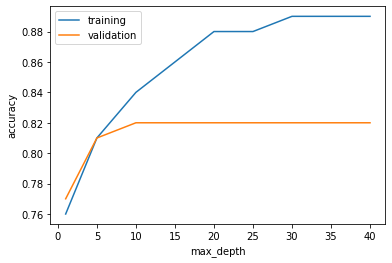

In [69]:
for i in range(len(train_errors)):
    train_errors[i] = 1 - train_errors[i]/len(y_pred)
    val_errors[i] = 1 - val_errors[i]/len(y_pred)

plt.plot(depths, train_errors, label="training")
plt.plot(depths, val_errors, label="validation")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

In [126]:
eps = 1e-5  # a small number
np.random.seed(69420)

class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, m=0):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.m = m

    @staticmethod
    def information_gain(X, y, thresh):
        lsplit = y[X < thresh]
        rsplit = y[X >= thresh]
        
        ans = DecisionTree.gini_impurity(X,y,thresh) - (len(lsplit)*DecisionTree.gini_impurity(X,lsplit,thresh) + len(rsplit)*DecisionTree.gini_impurity(X,rsplit,thresh))/len(y)
        return ans

    @staticmethod
    def gini_impurity(X, y, thresh):
        if len(y) == 0:
            return 0
        
        n_yes = 0
        n_no = 0
        for pred in y:
            if pred == 0:
                n_no += 1
            else:
                n_yes += 1
        p_yes = n_yes/len(y)
        p_no = n_no/len(y)
        
        return p_yes*(1-p_yes) + p_no*(1-p_no)

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0 and 0 <= self.m and self.m <= len(X[0]):
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            if self.m == 0:
                feature_idxs = np.arange(X.shape[1])
            else:
                feature_idxs = np.random.choice(np.arange(X.shape[1]), size=m, replace=False)
                feature_idxs.sort()
                
            X_f = X[:, feature_idxs]
                
            thresh = np.array([
                    np.linspace(np.min(X_f[:, i]) + eps, np.max(X_f[:, i]) - eps, num=10)
                    for i in range(X_f.shape[1])
            ])
                
            for i in range(X_f.shape[1]):
                gains.append([self.information_gain(X_f[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            print(self.pred)
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            if len(X) != 0:
                print("feat_idx:", self.split_idx)
                print("thresh:", self.thresh)
                print("")
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

In [128]:
# Basic decision tree
print("\n\nPart (a-b): simplified decision tree")
dt = DecisionTree(max_depth=3, feature_labels=features)
dt.fit(spam_train, spam_train_labels)

y_pred = dt.predict(X[0:1,])
print(y_pred)



Part (a-b): simplified decision tree
feat_idx: 28
thresh: 1e-05
idx1: [0]
[0.]
[0.]
[0.]
feat_idx: 31
thresh: 1e-05
idx0: [0]
feat_idx: 19
thresh: 1e-05
idx0: [0]
[1.]
[0.]
[0.]
[1.]
[1.]


In [142]:
# Spam Decision Tree submission
y_pred = dt.predict(Z)
results_to_csv(y_pred)

feat_idx: 28
thresh: 1e-05
idx0: [   0    2    3 ... 5851 5852 5854]
idx1: [   1    5   11 ... 5853 5855 5856]
feat_idx: 19
thresh: 1e-05
idx0: [   0    1    2 ... 3992 3993 3994]
idx1: [ 256  477 1772]
feat_idx: 29
thresh: 1e-05
idx0: [   0    1    2 ... 3985 3988 3991]
idx1: [   3    4    5 ... 3987 3989 3990]
[0.]
[0.]
[0.]
feat_idx: 31
thresh: 1e-05
idx0: [   0    1    3 ... 1858 1859 1861]
idx1: [   2   29   33   36   37   42   43   53   60   65   75   78   82   91
   93  103  106  113  115  131  145  146  154  170  174  182  188  190
  197  203  213  214  215  231  233  240  242  244  247  273  276  280
  286  291  293  315  316  319  324  327  340  345  353  356  378  381
  386  388  405  408  417  426  432  433  451  459  460  463  469  481
  498  499  504  513  514  525  526  554  556  557  559  566  576  578
  579  581  590  595  596  614  616  624  640  654  662  676  679  685
  691  696  703  713  714  717  727  733  757  759  780  783  786  797
  799  800  806  808  810  8